In [34]:
import os
import subprocess
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
import include.colors as colortools


In [35]:
def get_files(search_directory,search_term="log"):
    #FIXME rewrite to use python builtin functions for better portability
    """searches `search_directory' for files containing 'search_term' in the filename"""
    ls = subprocess.Popen(["ls", search_directory], stdout=subprocess.PIPE)
    process = subprocess.Popen(["grep", search_term], stdin=ls.stdout, stdout=subprocess.PIPE)
    stdout, stderr = process.communicate()
    return stdout.decode('utf-8').splitlines()

# Reduce data
After merging data from different seeds the QMC data is reduced over varying parameters. Here we reduce over fixed temperature $T={1.6,4.2}\mathrm{K}$ and system size $L=50.0\mathrm{\unicode{x212B}}$ with varying chemical potential and fixed chemical potential $\mu=-13.0\mathrm{K}$ and temperture $T=1.6$ with varying system size. 

In [36]:
path_to_reduce_script = "/path/to/reduce-one.py"
path_to_qmc_data = "/path/to/qmc_data/"
path_to_reduce_script = "/home/nsnichol/pimcscripts/reduce-one.py"
path_to_qmc_data = "/home/nsnichol/shared/Projects/PlatedHe4Nanopores/Data/Karst/OUTPUT/MERGED/"
for est in ['estimator','radial','super']:
    c = "{} -r u -L 50.0 -T 1.6 -e {} '{}'".format(path_to_reduce_script,est,path_to_qmc_data)
    %run $c
    
    c = "{} -r u -L 50.0 -T 4.2 -e {} '{}'".format(path_to_reduce_script,est,path_to_qmc_data)
    %run $c
    
    c = "{} -r L -u -13.0 -T 1.6 -e {} '{}'".format(path_to_reduce_script,est,path_to_qmc_data)
    %run $c

ERROR:root:File `'/home/nsnichol/pimcscripts/reduce-one.py'` not found.
ERROR:root:File `'/home/nsnichol/pimcscripts/reduce-one.py'` not found.
ERROR:root:File `'/home/nsnichol/pimcscripts/reduce-one.py'` not found.
ERROR:root:File `'/home/nsnichol/pimcscripts/reduce-one.py'` not found.
ERROR:root:File `'/home/nsnichol/pimcscripts/reduce-one.py'` not found.
ERROR:root:File `'/home/nsnichol/pimcscripts/reduce-one.py'` not found.
ERROR:root:File `'/home/nsnichol/pimcscripts/reduce-one.py'` not found.
ERROR:root:File `'/home/nsnichol/pimcscripts/reduce-one.py'` not found.
ERROR:root:File `'/home/nsnichol/pimcscripts/reduce-one.py'` not found.


# Load data
Now the reduced data is loaded into python dictionaries.

In [5]:
reduced_file_directory = "../Data/"
reduced_files = get_files(reduced_file_directory,"reduce")

In [6]:
# Keys based on QMC runs performed and reduced files.
reduce_keys = ["L-reduce-T-01.600-u--013.000","u-reduce-T-01.600-L-050.000","u-reduce-T-04.200-L-050.000"]

In [7]:
# Put data into dictionaries
estimators_dict=dict()
radial_dict=dict()
super_dict=dict()
for fn in reduced_files:
    for est in ['estimator','radial','super']:
        for key in reduce_keys:
            if (est == "estimator") & (est in fn) & (key in fn):
                # Load reduced data for scalar estimators
                estimators_dict[key]=np.genfromtxt(reduced_file_directory+fn,names=True)
            if (est == "radial") & (est in fn) & (key in fn):
                # Load and reshape reduced radial density estimator data for convenience
                radial = np.loadtxt(reduced_file_directory+fn)
                r_shape = np.shape(radial)
                radial = np.reshape(radial.T,(r_shape[1]//3,3,r_shape[0]))
                radial_dict[key]=radial
            if (est == "super") & (est in fn) & (key in fn):
                # Load reduced superfluid density estimator data
                super_dict[key]=np.genfromtxt(reduced_file_directory+fn,names=True)


In [8]:
#Extract varying variable from reduced data and store in dictionary
reduced_varying_parameters=dict()
key = "L-reduce-T-01.600-u--013.000"
reduced_varying_parameters[key] = estimators_dict[key]["L"]
key = "u-reduce-T-01.600-L-050.000"
reduced_varying_parameters[key] = estimators_dict[key]["u"]
key = "u-reduce-T-04.200-L-050.000"
reduced_varying_parameters[key] = estimators_dict[key]["u"]

# Scaling system size
Select scalar estimators and radial density were measured for various lengths of nanopore with fixed radius and chemical potential $\mu=-13.0\mathrm{K}$.

In [ ]:
key = "L-reduce-T-01.600-u--013.000"
radial = radial_dict[key]
unique_lengths = reduced_varying_parameters[key]
fig,ax = plt.subplots()
for i,L in enumerate(unique_lengths):
    ax.plot(radial[i][0,:],radial[i][1,:],label="$L={}\mathrm{{\AA}}$".format(L))
ax.legend(frameon=False,ncol = 2)
ax.set_xlim((0,10))

No major structural changes are seen as the system size increases. The coordination number of the central column of particles can be determined by integrating the radial density. First, we take a closer look and determine where the second layer starts forming.

In [ ]:
fig,ax = plt.subplots()
min_arr = [] # will store the location where the layer ends
x_arr = []
y_arr = []
yerr_arr = []
for i,L in enumerate(unique_lengths):
    x = radial[i][0,:]
    x_idx = x < 2
    xx = x[x_idx]
    y = radial[i][1,:]
    yy = y[x_idx]
    min_arr.append(xx[np.argmin(yy)])
    yerr = radial[i][2,:]
    ax.errorbar(x,y,yerr,label="$L={}\mathrm{{\AA}}$".format(L))
    x_arr.append(x)
    y_arr.append(y)
    yerr_arr.append(yerr)
ax.legend(frameon=False,ncol = 2)
ax.set_xlim((0,2))
x_arr = np.array(x_arr)
y_arr = np.array(y_arr)
yerr_arr = np.array(yerr_arr)

In [ ]:
np.savez("data/finite_size_effect_radial",L=unique_lengths,distance_from_center=x_arr,radial_density=y_arr,radial_density_error=yerr_arr)

Then we integrate the layer using Simpson's method.

In [ ]:
from scipy.integrate import simps
_tmp = []
for i in range(len(unique_lengths)):
    integrate_idx = radial[i][0,:] < min_arr[i]
    x = radial[i][0,:][integrate_idx]
    y = radial[i][1,:][integrate_idx]
    _tmp.append(simps(y*x,x=x))
_tmp=np.array(_tmp)
plt.plot(unique_lengths,_tmp*2*np.pi)
density_r_zero = [radial[i][1,0] for i in range(len(unique_lengths))]

In [ ]:
fig,ax = plt.subplots()
ax.plot(unique_lengths,density_r_zero)

While the density in the exact center varies in a nonintuitive way, the coordination number shows a strong linear relationship with cylinder length as expected.

In [ ]:
plt.errorbar(unique_lengths,estimators_dict["L-reduce-T-01.600-u--013.000"]["EN"],estimators_dict["L-reduce-T-01.600-u--013.000"]["ΔEN"])

# Scaling chemical potential
Chemical potential in QMC is related to the experimentally relevant pressure. A comparsion is made to expermental helium isotherms when filling the MCM-41 nanopores.

In [10]:
import include.helium as helium

In [11]:
#convert chemical potentials to pressure
reduced_pressures=dict()
key = "L-reduce-T-01.600-u--013.000"
reduced_pressures[key] = helium.pressure(-13.0,1.6)/helium.pressure_SVP(1.6)
key = "u-reduce-T-01.600-L-050.000"
reduced_pressures[key] = helium.pressure(estimators_dict[key]["u"],1.6)/helium.pressure_SVP(1.6)
key = "u-reduce-T-04.200-L-050.000"
reduced_pressures[key] = helium.pressure(estimators_dict[key]["u"],4.2)/helium.pressure_SVP(4.2)

/Users/agdelma/local/miniconda3/lib/python3.7/site-packages/pynverse/inverse.py:196: RuntimeWarning: Results obtained with less than 8 decimal digits of accuracy
  % accuracy, RuntimeWarning)
/Users/agdelma/local/miniconda3/lib/python3.7/site-packages/pynverse/inverse.py:196: RuntimeWarning: Results obtained with less than 8 decimal digits of accuracy
  % accuracy, RuntimeWarning)


In [12]:
temperature_dict = dict()
key = "L-reduce-T-01.600-u--013.000"
temperature_dict[key]=1.6
key = "u-reduce-T-01.600-L-050.000"
temperature_dict[key]=1.6
key = "u-reduce-T-04.200-L-050.000"
temperature_dict[key]=4.2

### Ideal Gas Law Chemical Potential
\begin{equation}
\mu_0 = k_{\rm B} T \ln \rho \lambda^d
\end{equation}

where $\lambda$ the thermal de Broglie wavelength is given by:

\begin{equation}
\lambda = \sqrt{\frac{2\pi\hbar^2}{m k_{\rm B} T}}
\end{equation}

In [24]:
def μₒ(T,ρ, d=3):
    '''Ideal gas bulk chemical potential. '''
    λ = helium.lambda_dB(T)*1E10
    return T * np.log(ρ * λ**d )

In [23]:
helium.lambda_dB(1.6)*1E10

6.898724424658841

In [26]:
μₒ(4.2,0.016)

0.887131075983669

Text(0.5, 0, '$P/P_0$')

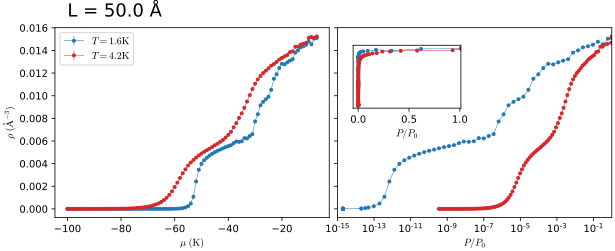

In [37]:
#stack vertically
#make inset μ vs P/P0
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as ticker

fig, axes = plt.subplots(1,2,sharex=False, sharey=True, squeeze=True, figsize=(10,3.5))
fig.subplots_adjust(wspace=0.03)
_colors = {"u-reduce-T-01.600-L-050.000":"C0","u-reduce-T-04.200-L-050.000":"C3"}
key = "u-reduce-T-01.600-L-050.000"
for key in ["u-reduce-T-01.600-L-050.000","u-reduce-T-04.200-L-050.000"]:
    axes[0].errorbar(estimators_dict[key]['u'],estimators_dict[key]['density'],yerr=estimators_dict[key]['Δdensity'], 
                     marker='o', markersize=3,lw=0.5, label="$T={}\mathrm{{K}}$".format(temperature_dict[key]),color=_colors[key])
    axes[1].errorbar(reduced_pressures[key],estimators_dict[key]['density'],yerr=estimators_dict[key]['Δdensity'], 
                     marker='o', markersize=3,lw=0.5, label="$T={}\mathrm{{K}}$".format(temperature_dict[key]),color=_colors[key])

# inset
#axins = inset_axes(axes[0], width="35%", height="25%", loc='lower right', borderpad=3)
axins = fig.add_axes([0.54, .56, .15, .25])
for key in ["u-reduce-T-01.600-L-050.000","u-reduce-T-04.200-L-050.000"]:
    axins.errorbar(reduced_pressures[key],estimators_dict[key]['density'],yerr=estimators_dict[key]['Δdensity'], 
                     marker='o', markersize=3,lw=0.5, label="$T={}\mathrm{{K}}$".format(temperature_dict[key]),color=_colors[key])

axins.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
axins.set_yticks([])
axins.set_xlim(-0.05,1.01)
axins.set_xlabel(r'$P/P_0$')

axes[0].text(-100,0.017,'L = {} Å'.format(50.0),fontsize=18)
axes[0].legend(loc='upper left')
axes[0].set_xlabel(r'$\mu\; (\mathrm{K})$')
axes[0].set_ylabel(r'$\rho\; (\mathrm{\AA}^{-3})$')    
axes[1].set_xscale('log')
axes[1].set_xlim(1E-15,1)
axes[1].set_xlabel(r'$P/P_0$')
#fig.savefig('../Output/rho_vs_mu_and_PoP03.png',dpi=300)

## Notes
- we want the RHS plot without the inset
- switch to viridis colors
- switch to APS stylefile

Text(0, 0.5, '$\\rho\\; (\\mathrm{\\AA}^{-3})$')

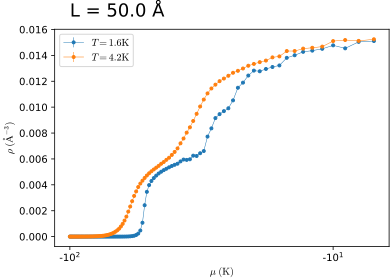

In [38]:
fig,ax = plt.subplots()
for key in ["u-reduce-T-01.600-L-050.000","u-reduce-T-04.200-L-050.000"]:
    ax.errorbar(estimators_dict[key]['u'],estimators_dict[key]['density'],yerr=estimators_dict[key]['Δdensity'], 
                marker='o', markersize=3,lw=0.5, label="$T={}\mathrm{{K}}$".format(temperature_dict[key]))
ax.set_xscale("symlog")
ax.text(-100,0.017,'L = {} Å'.format(50.0),fontsize=18)
ax.legend(loc='upper left')
ax.set_xlabel(r'$\mu\; (\mathrm{K})$')
ax.set_ylabel(r'$\rho\; (\mathrm{\AA}^{-3})$')  

The chemical potential picture conflicts with our physical intuition (in terms of pressure). Layer formation is expected to occur earlier at lower temperatures. A clearer picture is seen by converting to pressure and rescaling by helium pressure at SVP. Experimental helium isotherms were generated at $4.2\mathrm{K}$. An attempt is made to match the QMC data to experimental measurements.

In [39]:
#Load helium isotherm data performed at 4.2K
HeIsothermData = np.loadtxt('../Data/4He-isotherm.tsv')

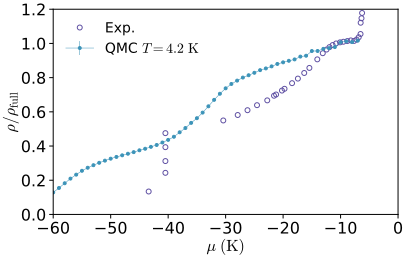

In [91]:
plt.style.reload_library()
with plt.style.context('./include/notebook.mplstyle'):

    fig,ax = plt.subplots()
    plt.plot(4.2*np.log(HeIsothermData[1:,0])-6,HeIsothermData[1:,1]/12.8, 'o', markersize=5, mfc='None', label='Exp.')
    for key in ["u-reduce-T-04.200-L-050.000"]:
        ax.errorbar(estimators_dict[key]['u'],estimators_dict[key]['density']/0.015,yerr=estimators_dict[key]['Δdensity'], 
                    marker='o', markersize=3,lw=0.5, label="QMC $T={}\ \mathrm{{K}}$".format(temperature_dict[key]))
    #ax.set_xscale("symlog")
    ax.legend(loc='upper left', frameon=False)
    ax.set_xlim(-60,0)
    ax.set_ylim(0,1.2)
    ax.set_xlabel(r'$\mu\; (\mathrm{K})$')
    ax.set_ylabel(r'$\rho/\rho_{\rm full}$')  
    fig.savefig('./plots/exp_theory_comparison.png')

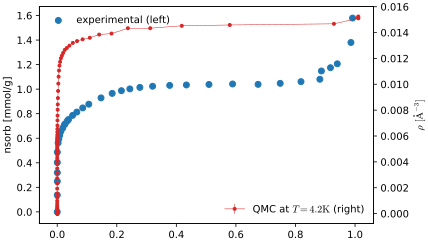

In [47]:
#plot the experimental data against the QMC data with the same x-axis
fig,ax = plt.subplots()
ax2 = ax.twinx()
ax.scatter(HeIsothermData[:,0],HeIsothermData[:,1],label="experimental (left)")
ax.set_ylabel("nsorb [mmol/g]")

key = "u-reduce-T-04.200-L-050.000"
ax2.errorbar(reduced_pressures[key],estimators_dict[key]['density'],yerr=estimators_dict[key]['Δdensity'], 
                     marker='o', color='C3',markersize=3,lw=0.5, label=r"QMC at $T={}\mathrm{{K}}$ (right)".format(temperature_dict[key]))
ax2.set_ylabel(r"$\rho$ $[\mathrm{\AA^{-3}}]$")
ax.legend(frameon=False)
ax2.legend(frameon=False)

In [41]:
mean_QMC_density_flat_idx = (reduced_pressures[key] > .2) & (reduced_pressures[key] < 1)
mean_HeIsotherm_density_flat_idx = (HeIsothermData[:,0] > .3) & (HeIsothermData[:,0] < .7)

mean_QMC_density_flat = np.mean(estimators_dict[key]['density'][mean_QMC_density_flat_idx])
mean_HeIsotherm_density_flat = np.mean(HeIsothermData[:,1][mean_HeIsotherm_density_flat_idx])

[click](figures_ArPlatedNanopores.ipynb#Figure-2:-Effective-potential)

[click](figures_ArPlatedNanopores.ipynb#section2)

In [ ]:
key

Text(0.5, 0, '$P/P_0$')

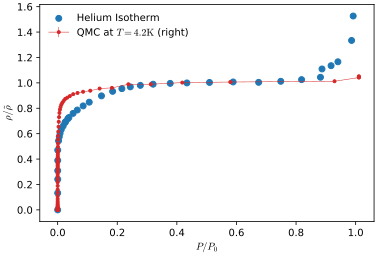

In [42]:
#this is plot 2

fig,ax = plt.subplots()
ax.scatter(HeIsothermData[:,0],HeIsothermData[:,1]/mean_HeIsotherm_density_flat, label="Helium Isotherm",color="C0")
ax.errorbar(reduced_pressures[key],estimators_dict[key]['density']/mean_QMC_density_flat,yerr=estimators_dict[key]['Δdensity']/mean_QMC_density_flat, 
             marker='o',markersize=3,lw=0.5, label=r"QMC at $T={}\mathrm{{K}}$ (right)".format(temperature_dict[key]),color="C3")
ax.legend(frameon=False)
#ax.set_xscale('log')

ax.set_ylabel(r"$\rho/\tilde{\rho}$")
ax.set_xlabel(r"$P/P_0$")

In [32]:
np.savez("data/density_vs_pressure_T4.2",
         helium_isotherm_pressure=HeIsothermData[:,0],
         helium_isotherm_density=HeIsothermData[:,1],
         qmc_pressure=reduced_pressures[key],
         qmc_density=estimators_dict[key]['density'],
         qmc_density_error=estimators_dict[key]['Δdensity']
         )

An attempt to match the densities is made by rescaling by the average density in the flat region.
- Make large $P/P_0$ open symbols to highlight issues with bulk/pore
- inset showing relating chemical potential to $P/P_0$
- update colors to viridis and update stylesheet
- change $\tilde{\rho}$ to $\rho_{0}$

## Connecting to the chemical potential

Text(0.5, 0, '$P/P_0$')

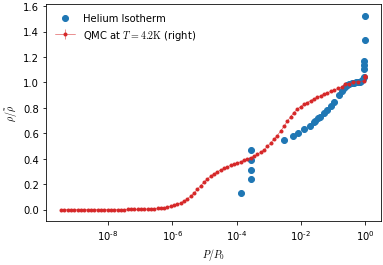

In [33]:
fig,ax = plt.subplots()
ax.scatter(HeIsothermData[:,0],HeIsothermData[:,1]/mean_HeIsotherm_density_flat, label="Helium Isotherm",color="C0")
ax.errorbar(reduced_pressures[key],estimators_dict[key]['density']/mean_QMC_density_flat,yerr=estimators_dict[key]['Δdensity']/mean_QMC_density_flat, 
             marker='o',markersize=3,lw=0.5, label=r"QMC at $T={}\mathrm{{K}}$ (right)".format(temperature_dict[key]),color="C3")
ax.legend(frameon=False)
ax.set_xscale('log')

ax.set_ylabel(r"$\rho/\tilde{\rho}$")
ax.set_xlabel(r"$P/P_0$")

More scaling is required for the pressures to account for additional effects. We use a scaling equation of the form
\begin{equation}
\tilde{P}(P,\alpha,\beta)=(1+\alpha)P - \beta
\end{equation}

In [79]:
def rescale_pressure(P,α,β):
    return (1.0+α)*P - β

Text(0.5, 0, '$P/P_0$')

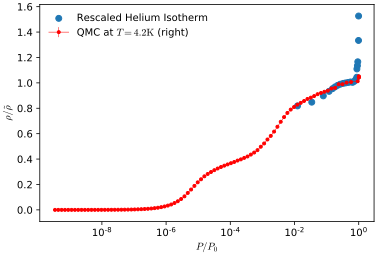

In [80]:
α=0.08
β=0.08

fig,ax = plt.subplots()
ax.scatter(rescale_pressure(HeIsothermData[:,0],α,β),HeIsothermData[:,1]/mean_HeIsotherm_density_flat, label="Rescaled Helium Isotherm")
ax.errorbar(reduced_pressures[key],estimators_dict[key]['density']/mean_QMC_density_flat,yerr=estimators_dict[key]['Δdensity']/mean_QMC_density_flat, 
             marker='o', color='r',markersize=3,lw=0.5, label=r"QMC at $T={}\mathrm{{K}}$ (right)".format(temperature_dict[key]))
ax.legend(frameon=False)
ax.set_xscale('log')

ax.set_ylabel(r"$\rho/\tilde{\rho}$")
ax.set_xlabel(r"$P/P_0$")

Measurements of the radial density were performed.

In [ ]:
estimators_dict["u-reduce-T-01.600-L-050.000"]["density"]

In [ ]:
key = "u-reduce-T-01.600-L-050.000"
radial = radial_dict[key]
chemical_potential = reduced_varying_parameters[key]
fig,ax = plt.subplots()
for i,u in enumerate(chemical_potential):
    if (u > -20) & (u < -14):
        ax.plot(radial[i][0,:],radial[i][1,:],label="$\mu={}\mathrm{{K}}$".format(u))
ax.legend(frameon=False)

In [ ]:
chemical_potential

In [ ]:
key = "u-reduce-T-01.600-L-050.000"
radial = radial_dict[key]
chemical_potential = reduced_varying_parameters[key]
μ = chemical_potential
_reduced_pressure = helium.pressure(chemical_potential,1.6)/helium.pressure_SVP(1.6)
μmin = -50
colors2 = colortools.get_linear_colors('Spectral',len(chemical_potential[chemical_potential>μmin]),reverse=False)
black = "k"
fig,ax = plt.subplots()
for i,u in enumerate(chemical_potential):
    if (u > μmin):
        x = radial[i][0,:]
        y = radial[i][1,:]
        yerr = radial[i][2,:]
        ax.errorbar(x,y,yerr, marker='o', lw=0.5, ms=1,
                      color=colors2[i], label=r'$\mu={:f}$'.format(chemical_potential[i]))
#ax.legend(frameon=False)

ax.set_xlabel(r'Distance From Center $(\mathrm{\AA})$', fontsize=20, color=black)
ax.set_xlim(0,11);
ax.xaxis.set_major_locator(ticker.MultipleLocator(2.5))
[ax.spines[sp].set_color(black) for sp in ['bottom','top','left','right']]
ax.xaxis.label.set_color(black)
ax.tick_params(which='both', colors=black)

ax.set_ylabel(r'Radial Density $(\mathrm{\AA}^{-3})$', fontsize=20, color=black)

# create the colorbar
sm = plt.cm.ScalarMappable(cmap=mpl.cm.Spectral_r, norm=plt.Normalize(vmin=μ[0], vmax=μmin))
sm._A = []
cb = plt.colorbar(sm)
cb.set_label(r'$\mu\; (\mathrm{K})$', color=black)

# set colorbar tick color
cb.ax.yaxis.set_tick_params(color=black)
# set colorbar edgecolor 
cb.outline.set_edgecolor(black)
# set colorbar ticklabels
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color=black)


In [ ]:
np.savez("data/radial_density_T1.6",chemical_potential=chemical_potential,reduced_pressure=_reduced_pressure,radial=radial)

An animation allows for a more useful exploration of the parameter space.

- switch to viridis
- update stylefile
- label with $P/P_0$ instead of $\mu$

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation

def update_lines(num, data, l, ye, t):
    r = data[0]
    param = data[1][num]
    x = r[num][0]
    y = r[num][1]
    yerr = r[num][2]
    t.set_text(r'$T = {:3.1f}\mathrm{{K}},\ L = {:}\mathrm{{\AA}},\ \mu = {}\mathrm{{K}}$'.format(1.6,50.0,param))
    segs = [np.array([[q,w-a],[q,w+a]]) for q,w,a in zip(x,y,yerr[i%2]*np.ones(x.shape[0]))]
    l.set_data(x,y)
    ye[0].set_segments(segs)
    return l, ye[0]

# First set up the figure, the axis, and the plot element we want to animate
fig,ax = plt.subplots(dpi=400)
t = ax.text(0.05,0.90,r'$T = {:3.1f}\mathrm{{K}},\ L = {:}\mathrm{{\AA}},\ \mu = {}\mathrm{{K}}$'.format(1.6,50.0,chemical_potential[-1]),fontsize=18, transform=ax.transAxes)
ax.set_xlabel(r'Distance From Center $(\mathrm{\AA})$')
ax.set_xlim(0,11);
ax.set_ylim(0,0.20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2.5))
ax.set_ylabel(r'Radial Density $(\mathrm{\AA}^{-3})$')
param = chemical_potential[-1]
l,xe,ye = ax.errorbar(*radial[-1], marker='o', lw=0.5, ms=1, label=r'$\mu={:f}$'.format(chemical_potential[-1]))

# Creating the Animation object
line_ani = animation.FuncAnimation(fig, update_lines, len(chemical_potential), fargs=((radial,chemical_potential), l, ye,t), interval=200, blit=True, repeat=False)




In [ ]:
from IPython.display import HTML
HTML(line_ani.to_html5_video())

In [ ]:
jsani = line_ani.to_jshtml()

In [ ]:
HTML(jsani)

In [ ]:
with open("radial-{}.html".format(key), "w") as text_file:
    print(jsani, file=text_file)

# Superfluid fraction
Finite superfluid fraction is found at certain chemical potentials.

In [ ]:
key = "u-reduce-T-01.600-L-050.000"
fig,ax = plt.subplots()
sff = super_dict[key]
ax.errorbar(sff['u'],sff['rho_srho'],sff['Δrho_srho'])
ax.set_ylabel(r"$\rho_s/\rho$")
ax.set_xlabel(r"$\mu$ $\mathrm{[K]}$")

Another video is made to explore the parameter space.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as ticker

def update_lines(num, data, lines, ye, t):
    l=lines[0]
    l2=lines[1]
    r = data[0]
    param = data[1][num]
    x = r[num][0]
    y = r[num][1]
    yerr = r[num][2]
    sff = data[2]
    t.set_text(r'$T = {:3.1f}\mathrm{{K}},\ L = {:}\mathrm{{\AA}},\ \mu = {}\mathrm{{K}}$'.format(1.6,50.0,param))
    segs = [np.array([[q,w-a],[q,w+a]]) for q,w,a in zip(x,y,yerr[i%2]*np.ones(x.shape[0]))]
    l.set_data(x,y)
    ye[0].set_segments(segs)
    l2.set_offsets(np.reshape([sff['u'][num],sff['rho_srho'][num]],(1,2)))
    return l, ye[0]

# First set up the figure, the axis, and the plot element we want to animate
fig,ax = plt.subplots(dpi=400)
t = ax.text(0.05,1.03,r'$T = {:3.1f}\mathrm{{K}},\ L = {:}\mathrm{{\AA}},\ \mu = {}\mathrm{{K}}$'.format(1.6,50.0,chemical_potential[-1]),fontsize=18, transform=ax.transAxes)
ax.set_xlabel(r'Distance From Center $(\mathrm{\AA})$')
ax.set_xlim(0,11);
ax.set_ylim(0,0.20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2.5))
ax.set_ylabel(r'Radial Density $(\mathrm{\AA}^{-3})$')
param = chemical_potential[-1]
l,xe,ye = ax.errorbar(*radial[-1], marker='o', lw=0.5, ms=1, label=r'$\mu={:f}$'.format(chemical_potential[-1]))

axins = fig.add_axes([0.255, .58, .5, .3])
axins.errorbar(sff['u'],sff['rho_srho'],sff['Δrho_srho'])
l2=axins.scatter(sff['u'][-1],sff['rho_srho'][-1],marker="s",color="r")
axins.set_ylabel(r"$\rho_s/\rho$")
axins.set_xlabel(r"$\mu$ $\mathrm{[K]}$")
for item in ([axins.title, axins.xaxis.label, axins.yaxis.label] +
             axins.get_xticklabels() + axins.get_yticklabels()):
    item.set_fontsize(8)

axins.set_yticks([0.000,0.001])

# Creating the Animation object
line_ani = animation.FuncAnimation(fig, update_lines, len(chemical_potential), fargs=((radial,chemical_potential,sff), (l,l2), ye,t), interval=200, blit=True, repeat=False)




In [ ]:
from IPython.display import HTML
HTML(line_ani.to_html5_video())

In [ ]:
jsani = line_ani.to_jshtml()

In [ ]:
HTML(jsani)

In [ ]:
with open("radial-sff-{}.html".format(key), "w") as text_file:
    print(jsani, file=text_file)

In [ ]:
50/(2*np.pi/50)

## Linear Density Inside the Pore

In [ ]:
#key = "L-reduce-T-01.600-u--013.000"
key = "u-reduce-T-01.600-L-050.000"
radial = radial_dict[key]
estimators_dict[key]["u"]
# unique_lengths = reduced_varying_parameters[key]
# fig,ax = plt.subplots()
# for i,L in enumerate(unique_lengths):
#     ax.plot(radial[i][0,:],radial[i][1,:],label="$L={}\mathrm{{\AA}}$".format(L))
# ax.legend(frameon=False,ncol = 2)
# ax.set_xlim((0,10))

In [ ]:
estimators_dict[key]["u"]

In [ ]:
radial[:,1,0].shape

In [ ]:
len(radial[0][1,:])

In [ ]:
plt.plot(estimators_dict[key]["u"],radial[:,1,:10])

In [ ]:
data = radial[0,:,:]
data.shape

In [ ]:
from scipy import integrate
from scipy.signal import argrelextrema
from math import pi as π

ρlin = {} 

μ = estimators_dict[key]["u"]
for key in ["u-reduce-T-01.600-L-050.000","u-reduce-T-04.200-L-050.000"]:
    ρlin[key] = np.zeros([len(μ),3])
    radial = radial_dict[key]
    # find the location of the minima
    data = radial[0,:,:]
    idx = argrelextrema(data[1], np.less)[0]
    rmin = data[0][idx]
    #rmin[0] = 1.25

    for i,param in enumerate(μ):
        
        # find the location of the first minimum
        r = radial[i][0]
        ρr = radial[i][1]
        min_idx = np.where(r>rmin[0])[0][0] 
        #min_idx = argrelextrema(ρr, np.less)[0][0]
        
        min_r = r[min_idx]
        
        ρlin[key][i,0] = integrate.simps(r[:min_idx]*ρr[:min_idx],r[:min_idx])*2*π

        min_idx = np.where(r>rmin[1])[0][0]
        min_r = r[min_idx]
        ρlin[key][i,1] = integrate.simps(r[:min_idx]*ρr[:min_idx],r[:min_idx])*2*π 

        min_idx = np.where(r>rmin[2])[0][0]
        min_r = r[min_idx]
        ρlin[key][i,2] = integrate.simps(r[:min_idx]*ρr[:min_idx],r[:min_idx])*2*π 

In [ ]:
fig, axes = plt.subplots(1,2,sharex=False, sharey=True, squeeze=True, figsize=(10,3.5))
fig.subplots_adjust(wspace=0.03)

for i,key in enumerate(["u-reduce-T-01.600-L-050.000","u-reduce-T-04.200-L-050.000"]):
    axes[i].plot(μ,ρlin[key][:,0],marker='o', markersize=3, lw=0.5, 
                 label=rf'$r < {rmin[0]:.3f}\, \mathrm{{\AA}}$')
    axes[i].plot(μ,ρlin[key][:,1],marker='o', mfc='w', markersize=3, lw=0.5, 
                 label=rf'$r < {rmin[1]:.3f}\, \mathrm{{\AA}}$')
    
    #axes[i].text(-88,2.75,'T = {:4.1f} K, L = {:d} Å'.format(cT,L),fontsize=18)


#plt.plot(μ,ρlin[:,2],marker='o', markersize=3, lw=0.5, label=r'$r < 7.5\, \mathrm{\AA}$')

    axes[i].set_xlim(-40,-5)
    #axes[i].set_ylim(0,0.3)

    axes[i].set_xlabel(r'$\mu\; (\mathrm{K})$')

axes[0].set_ylabel(r'Linear Density $(\mathrm{\AA}^{-1})$')
axes[0].legend(loc='lower right', frameon=False)
#plt.savefig('../Output/rholinear_vs_r.png',dpi=300)

In [ ]:
black = "#646362"
black = "k"
μmin = -50
fig, axes = plt.subplots(1,1,sharex=False, sharey=True, squeeze=True)
colors2 = colortools.get_linear_colors('Spectral',len(μ[μ>μmin]),reverse=False)

#keys = ["u-reduce-T-01.600-L-050.000","u-reduce-T-04.200-L-050.000"];
key = "u-reduce-T-01.600-L-050.000"
x = μ[μ>μmin]
y = ρlin[key][μ>μmin,0]
for i,u in enumerate(x):
    axes.plot(u,y[i],lw=1, marker='o', mec=colors2[i], markersize=6,
             mfc=colortools.get_alpha_hex(colors2[i],0.7),zorder=10)

    axes.plot(x[i-1:i+1],y[i-1:i+1],lw=1, marker='None', linestyle='-', color=colors2[i])

    

#axes.set_xlim(-40,-5)

#axes.set_xlabel(r'$P/P_0$', color=black, fontsize=20)
axes.set_xlabel(r'$\mu\; (\mathrm{K})$', color=black, fontsize=20)

[axes.spines[sp].set_color(black) for sp in ['bottom','top','left','right']]
axes.xaxis.label.set_color(black)
axes.tick_params(which='both', colors=black)

#axes.set_xscale('log')
#axes.set_xlim(1E-10,1)
#axes.set_ylim(0,0.018)

axes.set_ylabel(r'Core Density $(\mathrm{\AA}^{-1})$', color=black, fontsize=20)


In [ ]:
black = "#646362"
black = "k"
μmin = -50
fig, axes = plt.subplots(1,1,sharex=False, sharey=True, squeeze=True)
colors2 = colortools.get_linear_colors('Spectral',len(μ[μ>μmin]),reverse=False)

#keys = ["u-reduce-T-01.600-L-050.000","u-reduce-T-04.200-L-050.000"];
key = "u-reduce-T-04.200-L-050.000"
x = μ[μ>μmin]
y = ρlin[key][μ>μmin,0]
for i,u in enumerate(x):
    axes.plot(u,y[i],lw=1, marker='o', mec=colors2[i], markersize=6,
             mfc=colortools.get_alpha_hex(colors2[i],0.7),zorder=10)

    axes.plot(x[i-1:i+1],y[i-1:i+1],lw=1, marker='None', linestyle='-', color=colors2[i])

key = "u-reduce-T-01.600-L-050.000"
x = μ[μ>μmin]
y = ρlin[key][μ>μmin,0]
for i,u in enumerate(x):
    axes.plot(u,y[i],lw=1, marker='o', mec=colors2[i], markersize=6,
             mfc=colortools.get_alpha_hex(colors2[i],0.7),zorder=10)

    axes.plot(x[i-1:i+1],y[i-1:i+1],lw=1, marker='None', linestyle='-', color=colors2[i]) 

#axes.set_xlim(-40,-5)

#axes.set_xlabel(r'$P/P_0$', color=black, fontsize=20)
axes.set_xlabel(r'$\mu\; (\mathrm{K})$', color=black, fontsize=20)

[axes.spines[sp].set_color(black) for sp in ['bottom','top','left','right']]
axes.xaxis.label.set_color(black)
axes.tick_params(which='both', colors=black)

#axes.set_xscale('log')
#axes.set_xlim(1E-10,1)
#axes.set_ylim(0,0.018)

axes.set_ylabel(r'Core Density $(\mathrm{\AA}^{-1})$', color=black, fontsize=20)


In [ ]:
_reduced_pressure_T0 = helium.pressure(μ,1.6)/helium.pressure_SVP(1.6)
_reduced_pressure_T1 = helium.pressure(μ,4.2)/helium.pressure_SVP(4.2)


In [ ]:
μ.dtype

In [ ]:
np.array(μ,μ)

In [ ]:
np.savez("data/linear_density",chemical_potential=np.array(μ,μ),T=np.array([1.6,4.2]),reduced_pressure=np.array([_reduced_pressure_T0,_reduced_pressure_T1]),linear_density=np.array([ρlin["u-reduce-T-01.600-L-050.000"][:,0],ρlin["u-reduce-T-04.200-L-050.000"][:,0]]))

## Notes
- switch to viridis
- switch stylefile
- switch to $P/P_0$
- add temperature

In [ ]:
fig, axes = plt.subplots(1,1,sharex=False, sharey=True, squeeze=True)
μmin = -7
T
colors2 = colortools.get_linear_colors('Spectral',len(μ[μ>μmin]),reverse=False)


for i,cT in enumerate(T[:1]):
    for j,param in enumerate(radρ[Tkey(cT)].params):
        if float(param.split('=')[-1]) > μmin:
            axes.plot(x[Tkey(cT)][j],ρlin[Tkey(cT)][j,0],lw=1, marker='o', mec=colors2[j], markersize=6,
                     mfc=colortools.get_alpha_hex(colors2[j],0.7),zorder=10)
            
            axes.plot(x[Tkey(cT)][j-1:j+1],ρlin[Tkey(cT)][j-1:j+1,0],lw=1, marker='None', linestyle='-', color=colors2[j])
   
    #axes.set_xlim(-40,-5)

    axes.set_xlabel(r'$P/P_0$', color=black, fontsize=20)

    [axes.spines[sp].set_color(black) for sp in ['bottom','top','left','right']]
    axes.xaxis.label.set_color(black)
    axes.tick_params(which='both', colors=black)

    axes.set_xscale('log')
    axes.set_xlim(1E-10,1)
    #axes.set_ylim(0,0.018)

    axes.set_ylabel(r'Core Density $(\mathrm{\AA}^{-1})$', color=black, fontsize=20)
#plt.savefig('../Output/QFS2019/rholinear_vs_P.pdf')